In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1423
┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1423
┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1423


In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

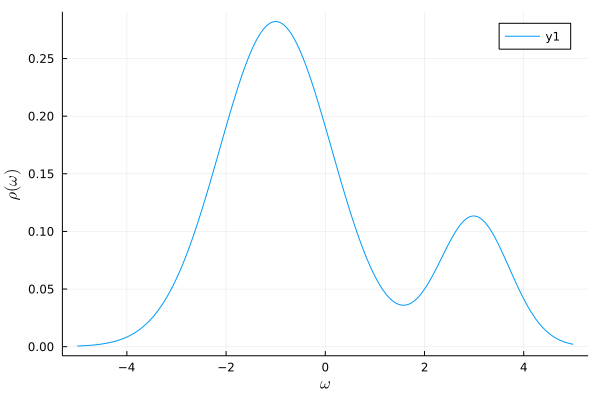

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian 23s
#rho(omega) = gaussian(omega, 0.0, 0.3)  

#on-centered lorentzian 2340s
#rho(omega) = lorentzian(omega, 0.0, 0.15)  

#two peak model 4403s
rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#rho(omega) = 0.8*lorentzian(omega, -1.0, 1.6) + 0.2*lorentzian(omega, 3, 1)

#three peak model 1255s
#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap 2619s
#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [5]:
beta = 100
wmax = 100
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;

In [6]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [7]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

52

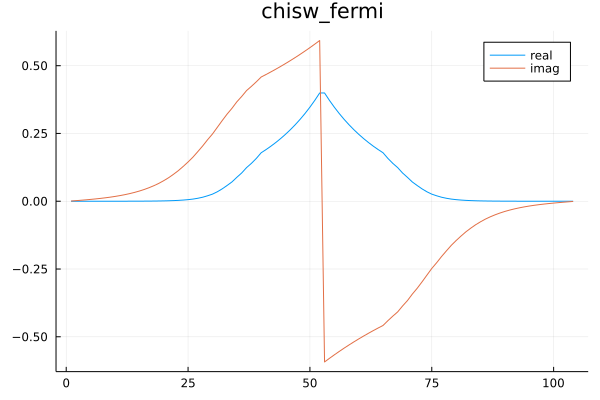

In [8]:
plot(title="chisw_fermi")
plot!(real.(gw[:]), label="real")
plot!(imag.(gw[:]), label="imag")

In [9]:
sum = -dot(IR_basis_set.basis_f.u(beta), gl) - dot(IR_basis_set.basis_f.u(0), gl)

0.9999999999999998

In [10]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [11]:
for i in 1:hnw
    test_smpl[i]= SparseIR.valueim(IR_basis_set.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(IR_basis_set))
    test_gw[i]  = gw[hnw+i]
end

In [25]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 15
println("N_imp $(N_imag)")
;

N_imp 31


In [91]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.546663e-02     1.444129e-01
 * time: 4.601478576660156e-5
     1     1.338551e-02     9.029074e-02
 * time: 0.24472498893737793
     2     5.140151e-03     1.256368e-01
 * time: 0.569098949432373
     3     4.213892e-03     5.806307e-03
 * time: 0.7755928039550781
     4     4.192681e-03     5.302027e-04
 * time: 1.1002378463745117
     5     4.192608e-03     1.286567e-04
 * time: 1.3096349239349365
     6     4.192606e-03     2.967798e-05
 * time: 1.6338229179382324
     7     4.192606e-03     7.353814e-06
 * time: 1.835033893585205
     8     4.192606e-03     1.136611e-06
 * time: 2.0367050170898438
     9     4.192606e-03     2.594389e-07
 * time: 2.366912841796875
    10     4.192606e-03     5.957816e-08
 * time: 2.610867977142334
    11     4.192606e-03     1.074538e-08
 * time: 2.8163909912109375
    12     4.192606e-03     2.773050e-09
 * time: 3.1405248641967773
max_theta=0.07934500

In [92]:
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     4.192606e-03     2.773050e-09
 * time: 0.0001690387725830078
max_theta=0.0793450089291150940753421876150977875986871703993721829509792309218484791272581141457773473447506917250763558000145263442278911479869805200220193391082336472
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     4.192606e-03     4.963044e-02
 * time: 0.00020313262939453125
     1     3.986686e-03     5.810318e-02
 * time: 0.27456212043762207
     2     2.928407e-03     6.980612e-02
 * time: 0.49846410751342773
     3     1.567830e-03     5.476523e-02
 * time: 0.7596721649169922
     4     1.351271e-03     1.436502e-02
 * time: 0.9864580631256104
     5     1.323897e-03     7.830275e-03
 * time: 1.3512911796569824
     6     1.304019e-03     1.223572e-02
 * time: 1.7110011577606201
     7     1.226941e-03     1.614642e-02
 * time: 2.0707650184631348
     8     1.188563e-03     8.610200e-03
 * time: 2.4291701316833496
     9   

    27     4.535260e-05     2.255792e-03
 * time: 12.414365768432617
    28     4.442771e-05     2.888255e-03
 * time: 12.869394779205322
    29     4.339558e-05     2.357297e-03
 * time: 13.3764967918396
    30     4.271334e-05     5.229491e-04
 * time: 13.838558912277222
    31     4.268096e-05     2.370355e-04
 * time: 14.175272941589355
    32     4.267512e-05     4.548999e-05
 * time: 14.463778972625732
    33     4.267489e-05     2.080530e-05
 * time: 14.966579914093018
    34     4.267485e-05     8.583972e-06
 * time: 15.304091930389404
    35     4.267484e-05     2.512900e-06
 * time: 15.598260879516602
    36     4.267484e-05     8.395409e-07
 * time: 16.102404832839966
    37     4.267484e-05     3.704964e-07
 * time: 16.3917019367218
    38     4.267484e-05     1.133949e-07
 * time: 16.727003812789917
    39     4.267484e-05     4.742752e-08
 * time: 17.06924080848694
    40     4.267484e-05     2.003049e-08
 * time: 17.362653970718384
    41     4.267484e-05     6.709858e-0

    45     7.603861e-06     7.027537e-05
 * time: 23.45634889602661
    46     7.602616e-06     1.367431e-04
 * time: 23.979687929153442
    47     7.600665e-06     1.927741e-04
 * time: 24.54912304878235
    48     7.596082e-06     3.074231e-04
 * time: 25.154916048049927
    49     7.589220e-06     4.105948e-04
 * time: 25.678083896636963
    50     7.573266e-06     6.170260e-04
 * time: 26.246551990509033
    51     7.549753e-06     8.001384e-04
 * time: 26.831856966018677
    52     7.497556e-06     1.134153e-03
 * time: 27.352455854415894
    53     7.421823e-06     1.395857e-03
 * time: 27.9236478805542
    54     7.266788e-06     1.692900e-03
 * time: 28.49871802330017
    55     7.050878e-06     1.580460e-03
 * time: 29.071842908859253
    56     6.742799e-06     6.377859e-04
 * time: 29.597128868103027
    57     6.679179e-06     4.001278e-04
 * time: 30.175627946853638
    58     6.667782e-06     9.308209e-05
 * time: 30.570050954818726
    59     6.666876e-06     4.070598e-0

     2     3.188633e-06     2.344625e-04
 * time: 0.8867299556732178
     3     3.181713e-06     1.719077e-04
 * time: 1.3356890678405762
     4     3.174123e-06     2.534965e-04
 * time: 1.7924981117248535
     5     3.163297e-06     2.138125e-04
 * time: 2.2232470512390137
     6     3.138782e-06     1.962431e-04
 * time: 2.6750431060791016
     7     3.124304e-06     1.905142e-04
 * time: 3.1170220375061035
     8     3.091788e-06     1.810368e-04
 * time: 3.7294881343841553
     9     3.062404e-06     1.340822e-04
 * time: 4.375683069229126
    10     3.032553e-06     1.081931e-04
 * time: 5.017874002456665
    11     3.018041e-06     7.417896e-05
 * time: 5.6664719581604
    12     2.966672e-06     2.060616e-04
 * time: 6.5363171100616455
    13     2.934503e-06     2.338256e-04
 * time: 7.192690134048462
    14     2.908276e-06     4.474761e-04
 * time: 7.863929033279419
    15     2.882807e-06     1.698393e-04
 * time: 8.524486064910889
    16     2.872725e-06     1.494393e-04
 

    10     1.989330e-06     9.829624e-05
 * time: 5.081556081771851
    11     1.982823e-06     8.467292e-05
 * time: 5.766019105911255
    12     1.967639e-06     9.006058e-05
 * time: 6.451229095458984
    13     1.963062e-06     6.517120e-05
 * time: 7.178174018859863
    14     1.958434e-06     5.053037e-05
 * time: 7.871493101119995
    15     1.953620e-06     2.121897e-04
 * time: 8.558424949645996
    16     1.941959e-06     2.236429e-04
 * time: 9.289278984069824
    17     1.914761e-06     1.338371e-04
 * time: 9.97520399093628
    18     1.909136e-06     7.266780e-05
 * time: 10.6581449508667
    19     1.903666e-06     1.354289e-04
 * time: 11.372595071792603
    20     1.901618e-06     7.055243e-05
 * time: 12.05605697631836
    21     1.899344e-06     7.526750e-05
 * time: 12.742877006530762
    22     1.897631e-06     5.334908e-05
 * time: 13.45412302017212
    23     1.896746e-06     5.072399e-05
 * time: 14.142833948135376
    24     1.896186e-06     6.531751e-05
 * tim

     0     1.591508e-06     8.867459e-05
 * time: 0.0002110004425048828
     1     1.591003e-06     9.376988e-05
 * time: 0.5000040531158447
     2     1.590684e-06     8.018147e-05
 * time: 0.9826550483703613
     3     1.590172e-06     5.536647e-05
 * time: 1.4989380836486816
     4     1.589553e-06     7.360778e-05
 * time: 1.9840869903564453
     5     1.588779e-06     7.254139e-05
 * time: 2.468440055847168
     6     1.587220e-06     7.176394e-05
 * time: 2.9589991569519043
     7     1.585712e-06     4.533718e-05
 * time: 3.4446280002593994
     8     1.583982e-06     8.162054e-05
 * time: 3.930352210998535
     9     1.581515e-06     4.266270e-05
 * time: 4.658579111099243
    10     1.579557e-06     4.688479e-05
 * time: 5.38638710975647
    11     1.575914e-06     9.482052e-05
 * time: 6.11309814453125
    12     1.573827e-06     4.136440e-05
 * time: 6.594232082366943
    13     1.571038e-06     6.409744e-05
 * time: 7.312770128250122
    14     1.567018e-06     8.434775e-05

   120     1.447205e-06     5.860940e-06
 * time: 78.9481770992279
   121     1.447203e-06     6.053321e-06
 * time: 79.46301507949829
   122     1.447199e-06     8.806095e-06
 * time: 80.20460414886475
   123     1.447196e-06     9.454999e-06
 * time: 80.71032810211182
   124     1.447187e-06     1.604770e-05
 * time: 81.48751616477966
   125     1.447179e-06     1.698461e-05
 * time: 81.99968218803406
   126     1.447155e-06     2.486925e-05
 * time: 82.75373601913452
   127     1.447137e-06     2.621234e-05
 * time: 83.24671912193298
   128     1.447078e-06     4.065626e-05
 * time: 84.0068781375885
   129     1.447033e-06     4.307503e-05
 * time: 84.51963210105896
   130     1.446889e-06     6.461563e-05
 * time: 85.27251815795898
   131     1.446777e-06     6.777788e-05
 * time: 85.76462912559509
   132     1.446422e-06     1.001860e-04
 * time: 86.52567911148071
   133     1.446145e-06     1.062564e-04
 * time: 87.03528499603271
   134     1.445269e-06     1.564852e-04
 * time: 

    79     1.393175e-06     7.218409e-05
 * time: 54.48566389083862
    80     1.392093e-06     2.578971e-05
 * time: 55.24733781814575
    81     1.392011e-06     1.424249e-05
 * time: 55.7579448223114
    82     1.391958e-06     3.910441e-06
 * time: 56.271503925323486
    83     1.391948e-06     6.646584e-06
 * time: 57.03123497962952
    84     1.391936e-06     7.911296e-06
 * time: 57.84143686294556
    85     1.391923e-06     9.980024e-06
 * time: 58.35308480262756
    86     1.391907e-06     1.364318e-05
 * time: 59.166828870773315
    87     1.391888e-06     1.779945e-05
 * time: 59.738605976104736
    88     1.391861e-06     2.290816e-05
 * time: 60.55558896064758
    89     1.391830e-06     2.748477e-05
 * time: 61.09990882873535
    90     1.391787e-06     3.435884e-05
 * time: 61.90065789222717
    91     1.391738e-06     4.024992e-05
 * time: 62.42734384536743
    92     1.391667e-06     4.923191e-05
 * time: 63.20814394950867
    93     1.391586e-06     5.644180e-05
 * ti

   199     1.354286e-06     4.440732e-07
 * time: 133.0369369983673
   200     1.354286e-06     2.981985e-07
 * time: 133.56099390983582
   201     1.354286e-06     1.600422e-07
 * time: 134.08087182044983
   202     1.354286e-06     1.095852e-07
 * time: 134.59284901618958
   203     1.354286e-06     6.448574e-08
 * time: 135.10673093795776
   204     1.354286e-06     4.333264e-08
 * time: 135.61414098739624
   205     1.354286e-06     2.395670e-08
 * time: 136.17240500450134
   206     1.354286e-06     1.547097e-08
 * time: 136.68018198013306
   207     1.354286e-06     9.032782e-09
 * time: 137.20143294334412
max_theta=0.401363280646061007541466611141296501499722080605687113142690563773838976382207934979465726232718178098575071521205245086075945166118967753602783453855537175
hardy optimization was success.
H=13
Iter     Function value   Gradient norm 
     0     1.354286e-06     2.893366e-05
 * time: 0.0002040863037109375
     1     1.354235e-06     2.820814e-05
 * time: 0.551454067

   108     1.344536e-06     4.887291e-06
 * time: 77.6254951953888
   109     1.344534e-06     5.090481e-06
 * time: 78.17358613014221
   110     1.344527e-06     9.515535e-06
 * time: 79.00889110565186
   111     1.344522e-06     9.147607e-06
 * time: 79.55572605133057
   112     1.344511e-06     1.496549e-05
 * time: 80.35797309875488
   113     1.344502e-06     1.474335e-05
 * time: 80.8956561088562
   114     1.344481e-06     2.267429e-05
 * time: 81.74065399169922
   115     1.344466e-06     2.286292e-05
 * time: 82.2973701953888
   116     1.344427e-06     3.262359e-05
 * time: 83.13880801200867
   117     1.344398e-06     3.311884e-05
 * time: 83.7004280090332
   118     1.344325e-06     4.551912e-05
 * time: 84.51688814163208
   119     1.344272e-06     4.665100e-05
 * time: 85.05334115028381
   120     1.344131e-06     6.059440e-05
 * time: 85.85736918449402
   121     1.344028e-06     6.262439e-05
 * time: 86.39183211326599
   122     1.343719e-06     7.178892e-05
 * time: 87

   228     1.328575e-06     3.425742e-05
 * time: 161.08250498771667
   229     1.328380e-06     1.281811e-05
 * time: 161.62154698371887
   230     1.328360e-06     7.094845e-06
 * time: 162.1738669872284
   231     1.328353e-06     6.014863e-06
 * time: 163.03308701515198
   232     1.328350e-06     3.152838e-06
 * time: 163.59445118904114
   233     1.328349e-06     2.038914e-06
 * time: 164.43711519241333
   234     1.328349e-06     9.713411e-07
 * time: 164.98533511161804
   235     1.328349e-06     9.002000e-07
 * time: 165.78914713859558
   236     1.328349e-06     3.727858e-07
 * time: 166.32555413246155
   237     1.328349e-06     2.954280e-07
 * time: 167.1268310546875
   238     1.328349e-06     1.434714e-07
 * time: 167.71368503570557
   239     1.328349e-06     1.110740e-07
 * time: 168.5527060031891
   240     1.328349e-06     4.374137e-08
 * time: 169.12114000320435
   241     1.328349e-06     4.162872e-08
 * time: 169.9397749900818
   242     1.328349e-06     1.862462e-

   100     1.324938e-06     1.714208e-05
 * time: 76.759770154953
   101     1.324877e-06     1.263898e-05
 * time: 77.92522120475769
   102     1.324864e-06     8.459140e-06
 * time: 78.49335813522339
   103     1.324853e-06     5.735438e-06
 * time: 79.05803203582764
   104     1.324850e-06     2.526910e-06
 * time: 79.7050130367279
   105     1.324848e-06     2.912938e-06
 * time: 80.57113218307495
   106     1.324847e-06     9.281467e-07
 * time: 81.16089415550232
   107     1.324847e-06     1.950832e-06
 * time: 82.01485419273376
   108     1.324846e-06     1.043582e-06
 * time: 82.58271503448486
   109     1.324846e-06     2.711748e-06
 * time: 83.4794671535492
   110     1.324845e-06     2.163177e-06
 * time: 84.05438899993896
   111     1.324844e-06     3.729523e-06
 * time: 84.93559002876282
   112     1.324844e-06     3.395581e-06
 * time: 85.50575613975525
   113     1.324843e-06     5.329986e-06
 * time: 86.35311913490295
   114     1.324842e-06     5.083613e-06
 * time: 86

   220     1.320056e-06     2.384511e-06
 * time: 158.7795181274414
   221     1.320056e-06     9.132165e-07
 * time: 159.3585181236267
   222     1.320056e-06     9.903396e-07
 * time: 160.23708605766296
   223     1.320056e-06     4.925534e-07
 * time: 160.80438113212585
   224     1.320056e-06     3.544822e-07
 * time: 161.6504909992218
   225     1.320056e-06     1.529934e-07
 * time: 162.27114009857178
   226     1.320056e-06     1.586656e-07
 * time: 163.15323305130005
   227     1.320056e-06     5.763601e-08
 * time: 163.73518800735474
   228     1.320056e-06     7.252690e-08
 * time: 164.5876591205597
   229     1.320056e-06     3.885363e-08
 * time: 165.15070414543152
   230     1.320056e-06     8.954286e-08
 * time: 166.05339121818542
   231     1.320056e-06     7.055455e-08
 * time: 166.63383603096008
   232     1.320056e-06     1.419905e-07
 * time: 167.514897108078
   233     1.320056e-06     1.226228e-07
 * time: 168.08334016799927
   234     1.320056e-06     2.225939e-07

    41     1.317115e-06     3.605605e-06
 * time: 32.827784061431885
    42     1.317109e-06     3.078522e-06
 * time: 33.71399688720703
    43     1.317106e-06     5.713216e-06
 * time: 34.370733976364136
    44     1.317100e-06     6.727059e-06
 * time: 35.290632009506226
    45     1.317096e-06     8.525024e-06
 * time: 35.88395285606384
    46     1.317088e-06     9.284648e-06
 * time: 36.77086091041565
    47     1.317082e-06     1.033037e-05
 * time: 37.42785906791687
    48     1.317071e-06     1.314826e-05
 * time: 38.37175488471985
    49     1.317064e-06     1.416027e-05
 * time: 39.01387691497803
    50     1.317049e-06     1.472083e-05
 * time: 39.899611949920654
    51     1.317038e-06     1.646011e-05
 * time: 40.84760284423828
    52     1.317007e-06     1.735731e-05
 * time: 41.77566599845886
    53     1.316938e-06     6.709868e-06
 * time: 42.96280288696289
    54     1.316921e-06     9.761626e-06
 * time: 43.55254507064819
    55     1.316914e-06     1.595618e-06
 * 

   161     1.316333e-06     8.751987e-07
 * time: 129.3918149471283
   162     1.316333e-06     1.686235e-06
 * time: 130.29235196113586
   163     1.316333e-06     1.454315e-06
 * time: 130.89758396148682
   164     1.316332e-06     2.411280e-06
 * time: 131.86584401130676
   165     1.316332e-06     2.220512e-06
 * time: 132.47589087486267
   166     1.316332e-06     3.282307e-06
 * time: 133.363126039505
   167     1.316331e-06     3.128483e-06
 * time: 133.95711398124695
   168     1.316331e-06     4.398263e-06
 * time: 134.92361998558044
   169     1.316330e-06     4.236005e-06
 * time: 135.5397548675537
   170     1.316329e-06     5.654050e-06
 * time: 136.43327403068542
   171     1.316328e-06     5.520811e-06
 * time: 137.02454686164856
   172     1.316327e-06     7.115532e-06
 * time: 137.97723388671875
   173     1.316326e-06     7.034563e-06
 * time: 138.59778594970703
   174     1.316324e-06     8.912763e-06
 * time: 139.51209497451782
   175     1.316322e-06     8.836088e-

   281     1.314396e-06     3.026134e-06
 * time: 210.71323704719543
   282     1.314396e-06     2.182568e-06
 * time: 211.30846285820007
   283     1.314395e-06     1.560165e-06
 * time: 211.90110206604004
   284     1.314395e-06     1.241779e-06
 * time: 212.55342292785645
   285     1.314395e-06     7.747828e-07
 * time: 213.16630005836487
   286     1.314395e-06     6.073816e-07
 * time: 213.78349900245667
   287     1.314395e-06     4.147796e-07
 * time: 214.3791959285736
   288     1.314394e-06     3.464195e-07
 * time: 214.97193098068237
   289     1.314394e-06     2.291288e-07
 * time: 215.56075501441956
   290     1.314394e-06     1.708643e-07
 * time: 216.21575593948364
   291     1.314394e-06     1.101190e-07
 * time: 216.83427500724792
   292     1.314394e-06     8.634100e-08
 * time: 217.434152841568
   293     1.314394e-06     5.486947e-08
 * time: 218.02528405189514
   294     1.314394e-06     4.611252e-08
 * time: 218.61622285842896
   295     1.314394e-06     2.756174e

   401     1.314308e-06     3.374058e-05
 * time: 284.6691429615021
   402     1.314294e-06     3.665315e-05
 * time: 285.58876299858093
   403     1.314280e-06     3.775924e-05
 * time: 286.1795928478241
   404     1.314259e-06     4.109924e-05
 * time: 287.06745195388794
   405     1.314236e-06     4.217540e-05
 * time: 288.0306670665741
   406     1.314196e-06     4.573262e-05
 * time: 288.9602918624878
   407     1.314140e-06     4.609222e-05
 * time: 289.87146186828613
   408     1.313962e-06     4.306782e-05
 * time: 290.82449197769165
   409     1.313437e-06     3.646641e-05
 * time: 292.04645800590515
   410     1.313354e-06     7.340394e-06
 * time: 292.6426169872284
   411     1.313337e-06     6.306133e-06
 * time: 293.5276930332184
   412     1.313329e-06     5.980658e-06
 * time: 294.4959030151367
   413     1.313327e-06     1.298923e-06
 * time: 295.1153779029846
   414     1.313326e-06     1.160312e-06
 * time: 296.01247906684875
   415     1.313326e-06     9.210048e-07
 

    88     1.312655e-06     2.652116e-06
 * time: 74.10211491584778
    89     1.312653e-06     2.183623e-06
 * time: 74.71189594268799
    90     1.312653e-06     1.933179e-06
 * time: 75.32430005073547
    91     1.312652e-06     2.188273e-06
 * time: 76.00478005409241
    92     1.312651e-06     2.474152e-06
 * time: 76.64134883880615
    93     1.312650e-06     2.987601e-06
 * time: 77.26533889770508
    94     1.312650e-06     3.104186e-06
 * time: 77.88235688209534
    95     1.312649e-06     3.810001e-06
 * time: 78.5561089515686
    96     1.312648e-06     4.050048e-06
 * time: 79.18829107284546
    97     1.312648e-06     4.600879e-06
 * time: 79.81090903282166
    98     1.312647e-06     5.015359e-06
 * time: 80.42246985435486
    99     1.312646e-06     5.519159e-06
 * time: 81.0322618484497
   100     1.312645e-06     5.990591e-06
 * time: 81.71359205245972
   101     1.312644e-06     6.588512e-06
 * time: 82.34546494483948
   102     1.312643e-06     7.106010e-06
 * time: 

   208     1.312378e-06     9.549482e-07
 * time: 169.29901385307312
   209     1.312377e-06     1.568592e-06
 * time: 170.3002769947052
   210     1.312377e-06     1.419922e-06
 * time: 170.9350118637085
   211     1.312377e-06     2.148217e-06
 * time: 171.86917304992676
   212     1.312377e-06     1.949182e-06
 * time: 172.48278403282166
   213     1.312377e-06     3.019166e-06
 * time: 173.48804783821106
   214     1.312376e-06     2.825209e-06
 * time: 174.12535786628723
   215     1.312376e-06     3.908920e-06
 * time: 175.0476589202881
   216     1.312375e-06     3.769124e-06
 * time: 175.6632809638977
   217     1.312374e-06     5.160179e-06
 * time: 176.6659529209137
   218     1.312374e-06     5.120202e-06
 * time: 177.29686188697815
   219     1.312372e-06     6.640814e-06
 * time: 178.21609687805176
   220     1.312371e-06     6.535505e-06
 * time: 178.88398599624634
   221     1.312368e-06     8.387271e-06
 * time: 179.84050798416138
   222     1.312367e-06     8.189187e-0

   328     1.312050e-06     1.839693e-05
 * time: 250.67862105369568
   329     1.312047e-06     1.890807e-05
 * time: 251.2886619567871
   330     1.312044e-06     2.011903e-05
 * time: 251.9682159423828
   331     1.312042e-06     2.068361e-05
 * time: 252.60762691497803
   332     1.312038e-06     2.198330e-05
 * time: 253.2358329296112
   333     1.312035e-06     2.260716e-05
 * time: 253.85691499710083
   334     1.312030e-06     2.399806e-05
 * time: 254.52495288848877
   335     1.312026e-06     2.468771e-05
 * time: 255.16027307510376
   336     1.312021e-06     2.617073e-05
 * time: 256.10636806488037
   337     1.312016e-06     2.693344e-05
 * time: 256.7164509296417
   338     1.312010e-06     2.850663e-05
 * time: 257.6919469833374
   339     1.312004e-06     2.935035e-05
 * time: 258.3285050392151
   340     1.311995e-06     3.100636e-05
 * time: 259.2593240737915
   341     1.311988e-06     3.193940e-05
 * time: 259.8726098537445
   342     1.311977e-06     3.365918e-05
 

    66     1.310799e-06     1.344987e-06
 * time: 54.571983098983765
    67     1.310798e-06     1.353006e-06
 * time: 55.17226600646973
    68     1.310798e-06     1.037462e-06
 * time: 55.770962953567505
    69     1.310798e-06     1.272630e-06
 * time: 56.35858201980591
    70     1.310797e-06     1.177174e-06
 * time: 56.956279039382935
    71     1.310797e-06     1.575450e-06
 * time: 57.56171011924744
    72     1.310797e-06     1.585300e-06
 * time: 58.162429094314575
    73     1.310797e-06     1.933738e-06
 * time: 58.74534010887146
    74     1.310796e-06     1.996458e-06
 * time: 59.33396816253662
    75     1.310796e-06     2.322042e-06
 * time: 59.90766406059265
    76     1.310796e-06     2.466876e-06
 * time: 60.51624798774719
    77     1.310795e-06     2.784399e-06
 * time: 61.10230898857117
    78     1.310795e-06     2.966480e-06
 * time: 61.69092512130737
    79     1.310795e-06     3.274952e-06
 * time: 62.280750036239624
    80     1.310795e-06     3.468996e-06
 *

   186     1.310562e-06     3.999673e-06
 * time: 137.73571395874023
   187     1.310561e-06     2.886665e-06
 * time: 138.34459805488586
   188     1.310561e-06     4.520391e-06
 * time: 139.23256397247314
   189     1.310561e-06     3.564918e-06
 * time: 139.80834197998047
   190     1.310560e-06     5.129960e-06
 * time: 140.701003074646
   191     1.310559e-06     4.266722e-06
 * time: 141.26412200927734
   192     1.310559e-06     5.759088e-06
 * time: 142.17704606056213
   193     1.310558e-06     4.987982e-06
 * time: 142.770357131958
   194     1.310557e-06     6.461848e-06
 * time: 143.6456639766693
   195     1.310557e-06     5.782368e-06
 * time: 144.25579714775085
   196     1.310556e-06     7.243905e-06
 * time: 145.12235403060913
   197     1.310555e-06     6.646718e-06
 * time: 145.7230920791626
   198     1.310554e-06     8.071633e-06
 * time: 146.62311506271362
   199     1.310553e-06     7.540598e-06
 * time: 147.2065269947052
   200     1.310552e-06     8.915501e-06


   306     1.310470e-06     5.060044e-07
 * time: 217.68393802642822
   307     1.310470e-06     5.811278e-07
 * time: 218.56133913993835
   308     1.310470e-06     5.831288e-07
 * time: 219.16828894615173
   309     1.310470e-06     6.637650e-07
 * time: 220.03998708724976
   310     1.310470e-06     6.673362e-07
 * time: 220.63908004760742
   311     1.310470e-06     7.538260e-07
 * time: 221.50729894638062
   312     1.310470e-06     7.587559e-07
 * time: 222.118155002594
   313     1.310470e-06     8.518257e-07
 * time: 222.98545598983765
   314     1.310470e-06     8.577759e-07
 * time: 223.59714794158936
   315     1.310470e-06     9.582821e-07
 * time: 224.4796850681305
   316     1.310470e-06     9.652803e-07
 * time: 225.06315207481384
   317     1.310470e-06     1.073868e-06
 * time: 225.96681308746338
   318     1.310470e-06     1.082162e-06
 * time: 226.54815101623535
   319     1.310470e-06     1.199333e-06
 * time: 227.48165011405945
   320     1.310470e-06     1.209108e

   426     1.310301e-06     1.290153e-06
 * time: 306.98384714126587
   427     1.310301e-06     1.549726e-06
 * time: 307.8551230430603
   428     1.310301e-06     1.503688e-06
 * time: 308.46431016921997
   429     1.310301e-06     1.797024e-06
 * time: 309.3376591205597
   430     1.310301e-06     1.747775e-06
 * time: 309.93888211250305
   431     1.310301e-06     2.076465e-06
 * time: 310.80842900276184
   432     1.310301e-06     2.021791e-06
 * time: 311.408931016922
   433     1.310301e-06     2.394928e-06
 * time: 312.27254700660706
   434     1.310300e-06     2.334238e-06
 * time: 312.88824105262756
   435     1.310300e-06     2.754039e-06
 * time: 313.75524711608887
   436     1.310300e-06     2.686316e-06
 * time: 314.3644859790802
   437     1.310300e-06     3.163422e-06
 * time: 315.2220690250397
   438     1.310300e-06     3.089364e-06
 * time: 315.82948112487793
   439     1.310300e-06     3.625893e-06
 * time: 316.71948504447937
   440     1.310300e-06     3.542434e-06

    39     1.309132e-06     2.560320e-06
 * time: 30.809741020202637
    40     1.309122e-06     7.901227e-06
 * time: 31.70043110847473
    41     1.309119e-06     3.864616e-06
 * time: 32.350038051605225
    42     1.309114e-06     5.476371e-06
 * time: 33.244322061538696
    43     1.309111e-06     3.933722e-06
 * time: 34.18491506576538
    44     1.309105e-06     4.670490e-06
 * time: 35.088207960128784
    45     1.309097e-06     4.972102e-06
 * time: 36.0346839427948
    46     1.309096e-06     3.367025e-06
 * time: 36.64227795600891
    47     1.309094e-06     2.495298e-06
 * time: 37.253612995147705
    48     1.309094e-06     1.685777e-06
 * time: 38.16318702697754
    49     1.309090e-06     5.487987e-06
 * time: 39.08106803894043
    50     1.309088e-06     3.249437e-06
 * time: 39.68251395225525
    51     1.309084e-06     6.038204e-06
 * time: 40.6003201007843
    52     1.309082e-06     4.038300e-06
 * time: 41.20355701446533
    53     1.309079e-06     6.744287e-06
 * t

   160     1.308747e-06     4.685526e-06
 * time: 115.49533605575562
   161     1.308746e-06     4.885990e-06
 * time: 116.09681606292725
   162     1.308746e-06     5.095534e-06
 * time: 116.72660994529724
   163     1.308745e-06     5.279744e-06
 * time: 117.31290197372437
   164     1.308745e-06     5.472770e-06
 * time: 117.94724011421204
   165     1.308744e-06     5.642428e-06
 * time: 118.56002497673035
   166     1.308744e-06     5.800366e-06
 * time: 119.4687819480896
   167     1.308743e-06     5.941994e-06
 * time: 120.3674430847168
   168     1.308742e-06     5.945322e-06
 * time: 121.28985595703125
   169     1.308739e-06     5.836307e-06
 * time: 122.20898199081421
   170     1.308723e-06     2.778240e-06
 * time: 123.41680312156677
   171     1.308721e-06     3.177086e-06
 * time: 124.04218006134033
   172     1.308718e-06     1.107855e-06
 * time: 124.63643407821655
   173     1.308718e-06     1.669730e-06
 * time: 125.25642609596252
   174     1.308718e-06     5.739339

   280     1.308671e-06     5.605592e-06
 * time: 196.86772394180298
   281     1.308670e-06     5.770701e-06
 * time: 197.48357892036438
   282     1.308670e-06     5.955305e-06
 * time: 198.09012508392334
   283     1.308670e-06     6.126889e-06
 * time: 198.6989870071411
   284     1.308669e-06     6.321139e-06
 * time: 199.29823303222656
   285     1.308669e-06     6.496767e-06
 * time: 200.22621393203735
   286     1.308668e-06     6.702527e-06
 * time: 200.83057498931885
   287     1.308668e-06     6.877446e-06
 * time: 201.7496099472046
   288     1.308667e-06     7.083780e-06
 * time: 202.67591404914856
   289     1.308666e-06     7.194283e-06
 * time: 203.57683205604553
   290     1.308663e-06     7.111073e-06
 * time: 204.50486993789673
   291     1.308643e-06     6.496399e-06
 * time: 205.7249140739441
   292     1.308639e-06     3.229959e-06
 * time: 206.3125491142273
   293     1.308634e-06     3.078113e-06
 * time: 207.25469088554382
   294     1.308633e-06     1.649337e-

   400     1.308362e-06     1.144805e-05
 * time: 289.1595239639282
   401     1.308360e-06     1.116988e-05
 * time: 289.7809829711914
   402     1.308356e-06     1.308122e-05
 * time: 290.6831328868866
   403     1.308353e-06     1.278442e-05
 * time: 291.29977893829346
   404     1.308347e-06     1.547281e-05
 * time: 292.22761511802673
   405     1.308344e-06     1.519929e-05
 * time: 292.8409640789032
   406     1.308335e-06     1.729665e-05
 * time: 293.7513349056244
   407     1.308330e-06     1.720914e-05
 * time: 294.33736300468445
   408     1.308318e-06     2.031829e-05
 * time: 295.2769250869751
   409     1.308311e-06     2.026539e-05
 * time: 295.8682060241699
   410     1.308293e-06     2.219284e-05
 * time: 296.7950789928436
   411     1.308284e-06     2.264886e-05
 * time: 297.3931291103363
   412     1.308259e-06     2.428428e-05
 * time: 298.31852889060974
   413     1.308243e-06     2.558220e-05
 * time: 298.9171869754791
   414     1.308197e-06     2.773287e-05
 * 

   520     1.307444e-06     4.266444e-06
 * time: 381.8160710334778
   521     1.307443e-06     2.227759e-06
 * time: 382.4397819042206
   522     1.307442e-06     2.702788e-06
 * time: 383.35451006889343
   523     1.307441e-06     1.222340e-06
 * time: 383.9600410461426
   524     1.307441e-06     1.536665e-06
 * time: 384.8828110694885
   525     1.307441e-06     9.321712e-07
 * time: 385.4850950241089
   526     1.307441e-06     9.206012e-07
 * time: 386.3804929256439
   527     1.307441e-06     4.754160e-07
 * time: 387.0115969181061
   528     1.307441e-06     5.452000e-07
 * time: 387.91434597969055
   529     1.307440e-06     2.321651e-07
 * time: 388.5379180908203
   530     1.307440e-06     3.156515e-07
 * time: 389.4422369003296
   531     1.307440e-06     1.485230e-07
 * time: 390.06669092178345
   532     1.307440e-06     1.772380e-07
 * time: 390.9686210155487
   533     1.307440e-06     9.376656e-08
 * time: 391.59258794784546
   534     1.307440e-06     1.049013e-07
 * 

    93     1.306338e-06     9.386549e-06
 * time: 76.35106110572815
    94     1.306328e-06     2.212540e-06
 * time: 77.01604199409485
    95     1.306319e-06     8.966520e-06
 * time: 77.64377212524414
    96     1.306310e-06     3.119429e-06
 * time: 78.3052179813385
    97     1.306302e-06     8.919395e-06
 * time: 78.9277081489563
    98     1.306293e-06     4.816837e-06
 * time: 79.58468794822693
    99     1.306286e-06     9.338543e-06
 * time: 80.23312497138977
   100     1.306279e-06     6.221712e-06
 * time: 80.8767671585083
   101     1.306273e-06     9.675214e-06
 * time: 81.52722406387329
   102     1.306267e-06     7.604004e-06
 * time: 82.49654412269592
   103     1.306262e-06     1.025496e-05
 * time: 83.1178650856018
   104     1.306256e-06     8.905970e-06
 * time: 84.11626410484314
   105     1.306251e-06     1.077453e-05
 * time: 85.08330202102661
   106     1.306243e-06     9.921410e-06
 * time: 86.03702211380005
   107     1.306228e-06     9.894520e-06
 * time: 87

   213     1.305643e-06     1.873932e-06
 * time: 166.27724814414978
   214     1.305642e-06     2.839461e-06
 * time: 167.26592302322388
   215     1.305642e-06     2.376367e-06
 * time: 167.91038393974304
   216     1.305642e-06     3.239141e-06
 * time: 168.8728699684143
   217     1.305641e-06     2.780611e-06
 * time: 169.53312015533447
   218     1.305641e-06     3.724605e-06
 * time: 170.49351906776428
   219     1.305640e-06     3.296962e-06
 * time: 171.14004015922546
   220     1.305640e-06     4.264026e-06
 * time: 172.1084520816803
   221     1.305639e-06     3.856964e-06
 * time: 172.7744071483612
   222     1.305639e-06     4.832382e-06
 * time: 173.73511505126953
   223     1.305638e-06     4.423045e-06
 * time: 174.35356307029724
   224     1.305637e-06     5.524673e-06
 * time: 175.34926414489746
   225     1.305636e-06     5.096784e-06
 * time: 175.98065614700317
   226     1.305635e-06     6.188612e-06
 * time: 176.9676821231842
   227     1.305634e-06     5.776443e-

   333     1.305417e-06     8.901833e-07
 * time: 264.67778611183167
   334     1.305416e-06     6.330040e-07
 * time: 265.30973505973816
   335     1.305416e-06     1.034221e-06
 * time: 266.29522609710693
   336     1.305416e-06     7.977132e-07
 * time: 266.93304109573364
   337     1.305416e-06     1.165856e-06
 * time: 267.87321400642395
   338     1.305416e-06     9.634993e-07
 * time: 268.54791498184204
   339     1.305416e-06     1.322765e-06
 * time: 269.50181102752686
   340     1.305416e-06     1.128969e-06
 * time: 270.16361904144287
   341     1.305416e-06     1.485829e-06
 * time: 271.1277461051941
   342     1.305416e-06     1.304500e-06
 * time: 271.77649211883545
   343     1.305416e-06     1.689085e-06
 * time: 272.7405230998993
   344     1.305416e-06     1.518807e-06
 * time: 273.36100816726685
   345     1.305416e-06     1.903182e-06
 * time: 274.3595311641693
   346     1.305416e-06     1.733519e-06
 * time: 274.99560713768005
   347     1.305416e-06     2.115074e

   453     1.305090e-06     5.933534e-07
 * time: 353.8863799571991
   454     1.305090e-06     6.049279e-07
 * time: 354.5350241661072
   455     1.305090e-06     6.479994e-07
 * time: 355.1914870738983
   456     1.305090e-06     6.599802e-07
 * time: 355.8358130455017
   457     1.305090e-06     7.045332e-07
 * time: 356.50867199897766
   458     1.305090e-06     7.171456e-07
 * time: 357.1502709388733
   459     1.305090e-06     7.631065e-07
 * time: 357.82258105278015
   460     1.305090e-06     7.764718e-07
 * time: 358.4548010826111
   461     1.305090e-06     8.238060e-07
 * time: 359.1422441005707
   462     1.305090e-06     8.379282e-07
 * time: 359.7930760383606
   463     1.305090e-06     8.867919e-07
 * time: 360.437047958374
   464     1.305090e-06     9.016056e-07
 * time: 361.08643102645874
   465     1.305090e-06     9.522651e-07
 * time: 361.72769594192505
   466     1.305090e-06     9.676861e-07
 * time: 362.3734109401703
   467     1.305090e-06     1.020303e-06
 * t

   573     1.305077e-06     1.207845e-05
 * time: 431.5942950248718
   574     1.305076e-06     1.227459e-05
 * time: 432.22663617134094
   575     1.305076e-06     1.258048e-05
 * time: 432.91503715515137
   576     1.305075e-06     1.279069e-05
 * time: 433.55475211143494
   577     1.305074e-06     1.310547e-05
 * time: 434.21423602104187
   578     1.305074e-06     1.333131e-05
 * time: 434.8348729610443
   579     1.305073e-06     1.365504e-05
 * time: 435.4927010536194
   580     1.305072e-06     1.389837e-05
 * time: 436.14556312561035
   581     1.305071e-06     1.423104e-05
 * time: 436.7888491153717
   582     1.305071e-06     1.449407e-05
 * time: 437.4411840438843
   583     1.305070e-06     1.483560e-05
 * time: 438.081267118454
   584     1.305069e-06     1.512100e-05
 * time: 438.733206987381
   585     1.305068e-06     1.547116e-05
 * time: 439.3700590133667
   586     1.305067e-06     1.578221e-05
 * time: 440.018963098526
   587     1.305066e-06     1.614063e-05
 * ti

   693     1.304468e-06     9.704772e-08
 * time: 512.1380319595337
   694     1.304468e-06     1.022431e-07
 * time: 512.8152351379395
   695     1.304468e-06     1.035782e-07
 * time: 513.4765610694885
   696     1.304468e-06     1.088654e-07
 * time: 514.1219871044159
   697     1.304468e-06     1.102905e-07
 * time: 514.7715840339661
   698     1.304468e-06     1.156849e-07
 * time: 515.4106810092926
   699     1.304468e-06     1.171978e-07
 * time: 516.059849023819
   700     1.304468e-06     1.227119e-07
 * time: 516.6938180923462
   701     1.304468e-06     1.243171e-07
 * time: 517.3420641422272
   702     1.304468e-06     1.299574e-07
 * time: 517.973268032074
   703     1.304468e-06     1.316605e-07
 * time: 518.6376450061798
   704     1.304468e-06     1.374294e-07
 * time: 519.2641839981079
   705     1.304468e-06     1.392329e-07
 * time: 519.9254529476166
   706     1.304468e-06     1.451329e-07
 * time: 520.5469419956207
   707     1.304468e-06     1.470362e-07
 * time: 

   814     1.304468e-06     1.197965e-06
 * time: 590.4850900173187
   815     1.304468e-06     1.209720e-06
 * time: 591.1262199878693
   816     1.304468e-06     1.237778e-06
 * time: 591.7734179496765
   817     1.304468e-06     1.249854e-06
 * time: 592.412260055542
   818     1.304468e-06     1.278795e-06
 * time: 593.0849349498749
   819     1.304468e-06     1.291199e-06
 * time: 593.7269229888916
   820     1.304468e-06     1.321052e-06
 * time: 594.3886070251465
   821     1.304468e-06     1.333790e-06
 * time: 595.0227701663971
   822     1.304468e-06     1.364587e-06
 * time: 595.6826810836792
   823     1.304468e-06     1.377666e-06
 * time: 596.3123879432678
   824     1.304468e-06     1.409439e-06
 * time: 596.9728879928589
   825     1.304468e-06     1.422865e-06
 * time: 597.6003260612488
   826     1.304468e-06     1.455648e-06
 * time: 598.2605681419373
   827     1.304468e-06     1.469427e-06
 * time: 598.8822820186615
   828     1.304468e-06     1.503255e-06
 * time:

   935     1.304463e-06     7.814046e-06
 * time: 668.8292219638824
   936     1.304463e-06     8.053198e-06
 * time: 669.466943025589
   937     1.304463e-06     8.055983e-06
 * time: 670.1158361434937
   938     1.304463e-06     8.306555e-06
 * time: 670.7484769821167
   939     1.304462e-06     8.305563e-06
 * time: 671.3946490287781
   940     1.304462e-06     8.568314e-06
 * time: 672.0267140865326
   941     1.304462e-06     8.563060e-06
 * time: 672.6953151226044
   942     1.304462e-06     8.838820e-06
 * time: 673.3530559539795
   943     1.304462e-06     8.828759e-06
 * time: 674.0149481296539
   944     1.304461e-06     9.118440e-06
 * time: 674.6424810886383
   945     1.304461e-06     9.102963e-06
 * time: 675.300910949707
   946     1.304461e-06     9.407565e-06
 * time: 675.9210159778595
   947     1.304461e-06     9.385988e-06
 * time: 676.5959441661835
   948     1.304460e-06     9.706614e-06
 * time: 677.2162561416626
   949     1.304460e-06     9.678165e-06
 * time: 

In [93]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


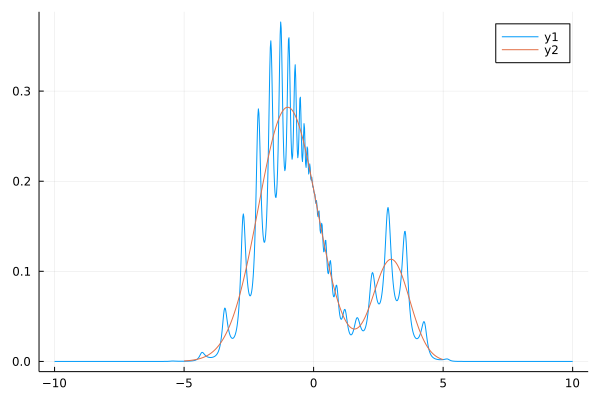

In [94]:
plot(real.(raw_reals.freq), imag.(raw_reals.val)/pi)
plot!(omegas, rho.(omegas))

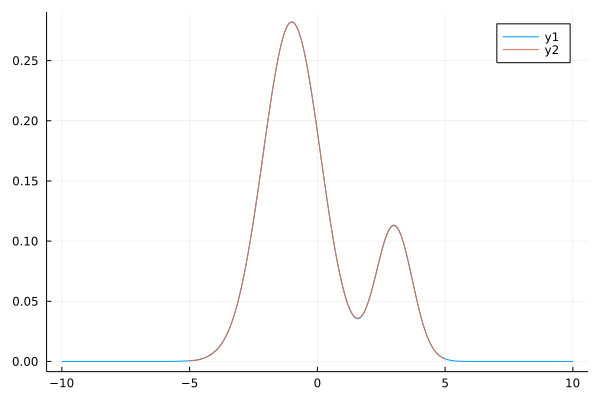

In [95]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [37]:
imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
#noopt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#opt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#noopt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
#opt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
noopt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
opt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
noopt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
opt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, noopt_raw_reals, phis)
ab_coeff  = zeros(ComplexF64, 2*sol.H) 
hardy_matrix = Nevanlinna.calc_hardy_matrix(noopt_raw_reals, sol.H)

Nevanlinna.evaluation!(noopt_raw_reals, abcd, sol.H, ab_coeff, hardy_matrix)
Nevanlinna.evaluation!(opt_raw_reals, abcd, sol.H, sol.ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.


LoadError: MethodError: no method matching RealDomainData(::Int64, ::Float64, ::Float64; T=BigFloat)
[0mClosest candidates are:
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m; T, small_omega, mesh) at ~/work/Nevanlinna/src/data.jl:55
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m, [91m::Array{Complex{T}, 1}[39m, [91m::Array{Complex{T}, 1}[39m) where T<:Real at ~/work/Nevanlinna/src/data.jl:47[91m got unsupported keyword argument "T"[39m

In [38]:
using FastGaussQuadrature
using OMEinsum
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_green_z(z::Vector{ComplexF64}, xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    newaxis = [CartesianIndex()]
    green_z = ein"q,q,wq->w"(
            quad_rule[2],
            rho.(quad_rule[1]),
            1 ./ (z[:, newaxis] .- quad_rule[1][newaxis, :])
        )
    return green_z
end
#exact_g = calc_green_z(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag])*im*pi/beta, -omega_max, omega_max, 1000)
exact_g = calc_green_z(((collect(1:200).-100)/1000000)*2*pi*im/beta, -omega_max, omega_max, 1000000)

;

LoadError: ArgumentError: Package FastGaussQuadrature not found in current path:
- Run `import Pkg; Pkg.add("FastGaussQuadrature")` to install the FastGaussQuadrature package.


In [39]:
using FastGaussQuadrature
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_sum_omega(xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    sum_omega = 0.0
    for i in 1:deg
        sum_omega += (quad_rule[2] .* rho.(quad_rule[1]))[i]
    end

    return sum_omega
end
sum_o = calc_sum_omega(-omega_max, omega_max, 1000)

LoadError: ArgumentError: Package FastGaussQuadrature not found in current path:
- Run `import Pkg; Pkg.add("FastGaussQuadrature")` to install the FastGaussQuadrature package.


In [40]:
exact_g[11]

LoadError: UndefVarError: exact_g not defined

In [41]:
plot()
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(exact_g)), xlim=[0,0.3],label="real_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-opt_raw_reals.val)), label="real_nopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(exact_g)), xlim=[0,0.01],label="imag_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-opt_raw_reals.val)), label="imag_nopt_dense")

LoadError: UndefVarError: exact_g not defined

In [42]:
plot()
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-noopt_raw_reals.val-exact_g)), xlim = [0,0.01], label="real_nonopt_dense", xlabel=latexstring("\\omega"), ylabel=latexstring("|\\Delta G(i\\omega_\\nu)|"), yaxis=:log)
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-opt_raw_reals.val-exact_g)), label="real_opt_dense")

LoadError: UndefVarError: noopt_raw_reals not defined

In [43]:
#plot()
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(exact_g)), label="real_exact", xlabel=latexstring("\\nu"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-opt_raw_reals.val)), label="real_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(real.(test_gw[1:N_imag])), label="real_sparse")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(exact_g)), label="imag_exact")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-opt_raw_reals.val)), label="imag_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(imag.(test_gw[1:N_imag])), label="imag_sparse")

In [25]:
#plot()
#plot(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-noopt_raw_reals.val.-exact_g)), yaxis=:log, label="abs_nonopt_dense", xlabel=latexstring("\\nu"), ylabel=latexstring("\\Delta |G(i\\omega_\\nu)|"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-opt_raw_reals.val-exact_g)), label="abs_opt_dense")

In [26]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [27]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#